# explore the BOKU NDVI data WITH ONLY PRECIP / VCI -> VCI3M

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
EXPERIMENT =      'one_month_forecast_BOKU_VCI3M_our_vars_only_P_VCI'
TRUE_EXPERIMENT = 'one_month_forecast_BOKU_VCI3M_our_vars_only_P_VCI'
TARGET_VAR =      'VCI3M'

# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
print("ALL DATA:")
display(ds)
print('\n\n')
print("TARGET VARIABLE:")
display(y_test)

assert TARGET_VAR == [v for v in y_test.data_vars][0]

ALL DATA:


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan ... 43.83 82.86 37.45
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.6




TARGET VARIABLE:


<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    VCI3M    (time, lat, lon) float64 67.14 54.59 85.09 71.25 ... nan nan nan

In [7]:
ignore_vars = [
        "p84.162",
        "sp",
        "tp",
        "Eb",
        "VCI",
        "modis_ndvi",
        "pev",
        "t2m",
        "E",
        "SMroot",
        "SMsurf"
    ]

ds.drop(ignore_vars)

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 205)
Coordinates:
  * time      (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon       (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI3M     (time, lat, lon) float64 nan nan nan nan ... 43.83 82.86 37.45
    precip    (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    boku_VCI  (time, lat, lon) float64 100.0 100.0 98.82 37.64 ... nan nan nan

In [13]:
from src.utils import get_ds_mask
# mask = get_ds_mask(X_train.VCI)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)

Text(0.5, 1.0, '** PREDICTED VALUES **')

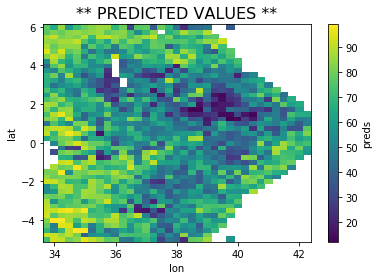

In [14]:
fig, ax = plt.subplots()
lstm_pred.isel(time=0).plot(ax=ax)
ax.set_title("** PREDICTED VALUES **", size=16)

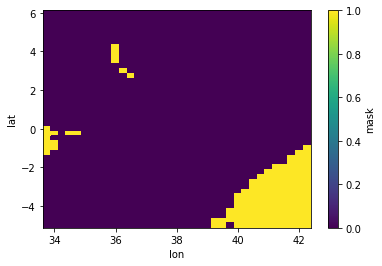

In [15]:
mask.plot()

### Model Performance Data

In [21]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_rmse.mean().values
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values

print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      7.03
ealstm_mean RMSE:    6.65
bline_mean RMSE:     11.55


# Model Performance

In [22]:
print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      7.03
ealstm_mean RMSE:    6.65
bline_mean RMSE:     11.55


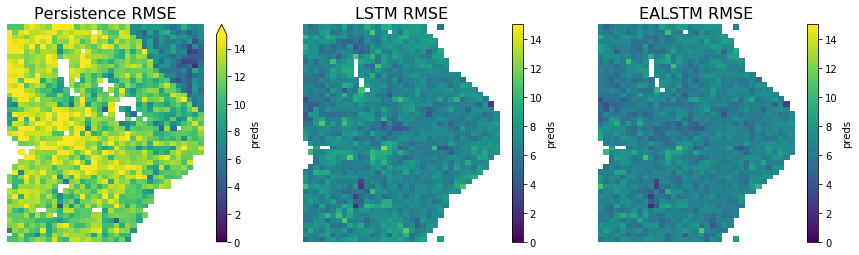

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
kwargs = {'vmin': 0, 'vmax': 15}

bline_rmse.plot(ax=axs[0], **kwargs)
axs[0].set_title('Persistence RMSE', size=16);

lstm_rmse.plot(ax=axs[1], **kwargs)
axs[1].set_title('LSTM RMSE', size=16);

ealstm_rmse.plot(ax=axs[2], **kwargs)
axs[2].set_title('EALSTM RMSE', size=16);

for ax in axs:
    ax.set_axis_off()

### Error over time

In [24]:
def calculate_error(true_da, pred_da, method=None):
    if method == 'squared':
        vals = (true_da.values - pred_da.values) ** 2
    elif method == 'absolute':
        vals = abs((true_da.values - pred_da.values))
    else:
        vals = (true_da.values - pred_da.values)
    da = xr.ones_like(true_da) * vals
    return da.rename(f'{method + "_" if method is not None else ""}error')


ealstm_error = calculate_error(
    pred_da=ealstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
lstm_error = calculate_error(
    pred_da=lstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
bline_error = calculate_error(
    pred_da=bline_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)

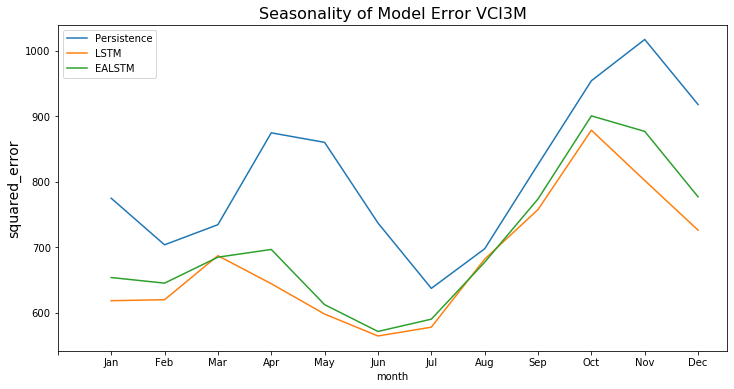

In [25]:
import calendar 
mths = [m for m in calendar.month_abbr]
fig, ax = plt.subplots(figsize=(12, 6))

bline_error.groupby('time.month').mean().plot(ax=ax, label='Persistence')
lstm_error.groupby('time.month').mean().plot(ax=ax, label='LSTM')
ealstm_error.groupby('time.month').mean().plot(ax=ax, label='EALSTM')
plt.legend()

ax.set_title(f'Seasonality of Model Error {TARGET_VAR}', size=16);
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
ax.set_ylabel(bline_error.name, size=14)
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png');

#### How does persistence error vary and how does that correspond with the raw NDVI values?

Note: the interpretation of this error is always slightly difficult because the VCI is de-seasonalised and so we do not expect to find any seasonal pattern in the VCI (nor necessarily our results)...

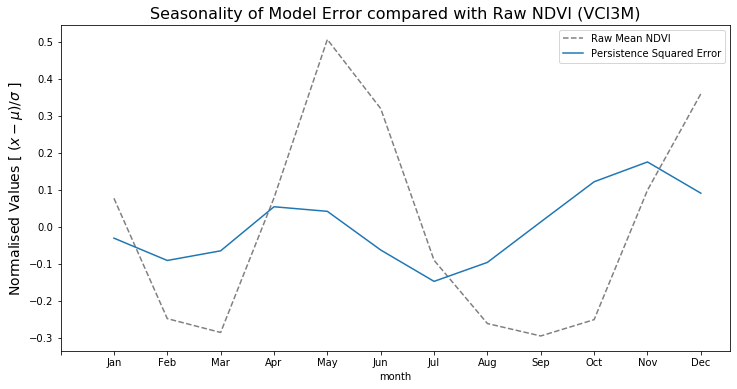

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the persistence model error seasonality (Error)
(
    (bline_error.groupby('time.month').mean() - bline_error.mean()) / bline_error.std()
).plot(ax=ax, label='Persistence Squared Error')

ax.set_title(f'Seasonality of Model Error compared with Raw NDVI ({TARGET_VAR})', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png')

### What if we compare our VCI products? 
It looks pretty fucked truth be told. It looks like the BOKU VCI must have an error in the calculation

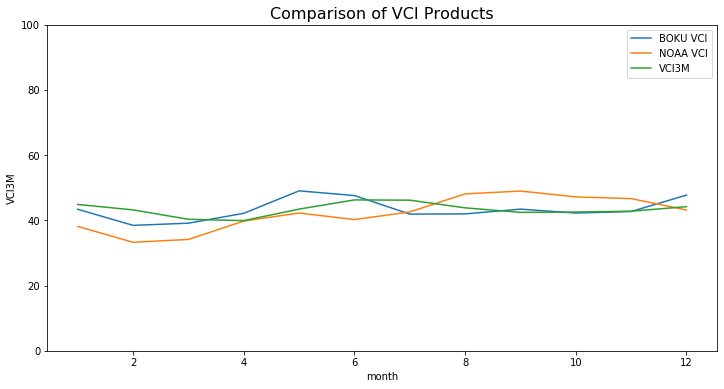

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ds.boku_VCI.groupby('time.month').mean().plot(ax=ax, label='BOKU VCI')
ds.VCI.groupby('time.month').mean().plot(ax=ax, label='NOAA VCI')
ds.VCI3M.groupby('time.month').mean().plot(ax=ax, label='VCI3M')
ax.set_title(f'Comparison of VCI Products', size=16);
ax.set_ylim([0, 100])
plt.legend();

fig.savefig(plot_dir / f'VCI_product_seasonality.png')

### Have we normalised the seasonality?

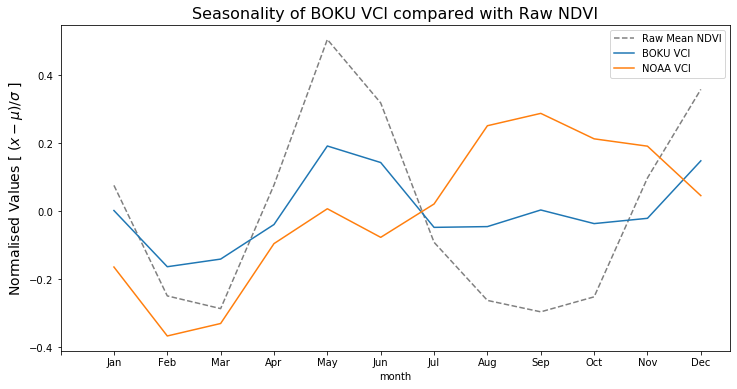

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the BOKU VCI
(
    (ds.boku_VCI.groupby('time.month').mean() - ds.boku_VCI.mean()) / ds.boku_VCI.std()   
).plot(ax=ax, label='BOKU VCI')

# normalise the NOAA VCI seasonality (Error)
(
    (ds.VCI.groupby('time.month').mean() - ds.VCI.mean()) / ds.VCI.std()   
).plot(ax=ax, label='NOAA VCI')


ax.set_title('Seasonality of BOKU VCI compared with Raw NDVI', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig('/Users/tommylees/Downloads/model_VCI_NDVI_seasonality.png')

# Region Analysis

In [29]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT
)
r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast_BOKU_VCI3M_our_vars_only_P_VCI
Models: ['ealstm', 'previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


In [30]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [31]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

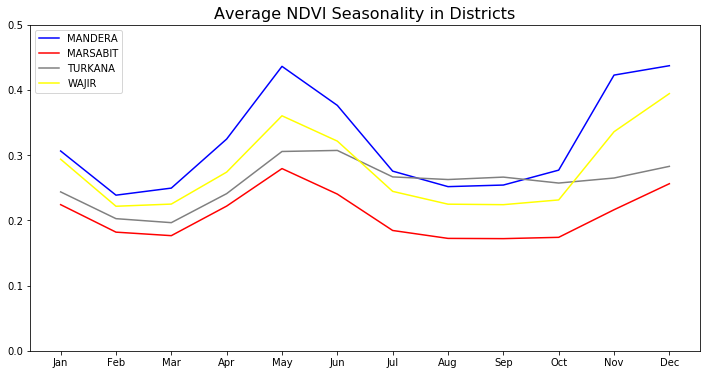

In [32]:
import calendar
mths = [m for m in calendar.month_abbr if m != ""]

colors = ['blue', 'red', 'grey', 'yellow']
regions = ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]
fig, ax = plt.subplots(figsize=(12, 6))
for ix, region in enumerate(regions):
    msk = get_region_mask(region)
    df = ds.modis_ndvi.where(msk).groupby('time.month').mean().to_dataframe().set_index(pd.Series(mths)).rename(columns={'modis_ndvi': region})

    df.plot(ax=ax, color=colors[ix])

ax.set_ylim([0, 0.5])
ax.set_xticks([i for i in range(0, 12)])
ax.set_xticklabels(mths)
plt.legend()
ax.set_title('Average NDVI Seasonality in Districts', size=16);


### Make region dataframe

In [33]:
import pickle

analyzer.analyze()

* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **

** Analyzing for rnn-district_l2_kenya **
** Written rnn csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/rnn/rnn_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_BOKU_VCI3M_our_vars_only_P_VCI_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to data/analysis/region_analysis/regional_error_metrics_one_month_forecast_BOKU_VCI3M_our_vars

In [34]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [35]:
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2016-01-31,NAIROBI,72.298599,81.994967,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2016-01-31,NAIROBI,69.254288,81.994967,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,previous_month,2016-01-31,NAIROBI,64.466231,81.994967,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,rnn,2016-02-29,NAIROBI,82.473618,90.583788,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,ealstm,2016-02-29,NAIROBI,83.227036,90.583788,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


### Seasonality of Performance?

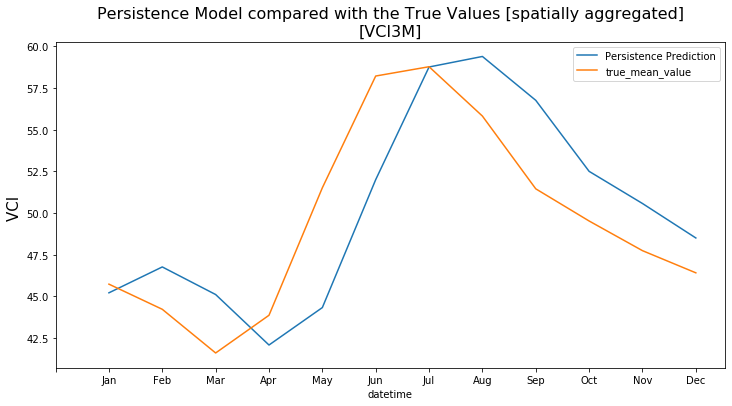

In [36]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'previous_month')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'Persistence Prediction'}).plot(ax=ax)
ax.set_title(f'Persistence Model compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)

fig.savefig(f'/Users/tommylees/Downloads/persistence_model_seasonality_{TARGET_VAR}.png')

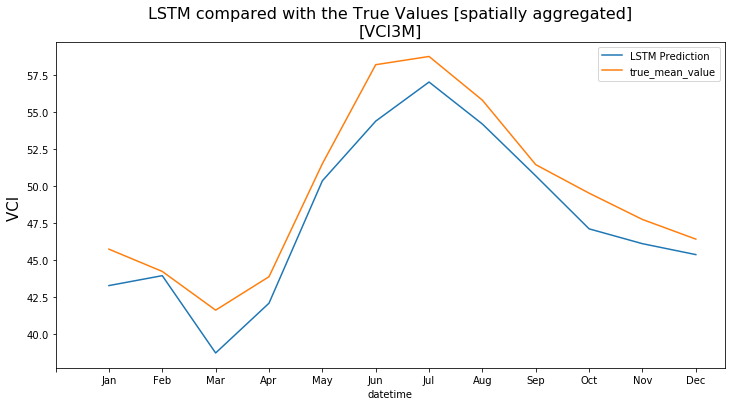

In [37]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'LSTM Prediction'}).plot(ax=ax)
ax.set_title(f'LSTM compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)


fig.savefig(f'/Users/tommylees/Downloads/lstm_model_seasonality_{TARGET_VAR}.png')

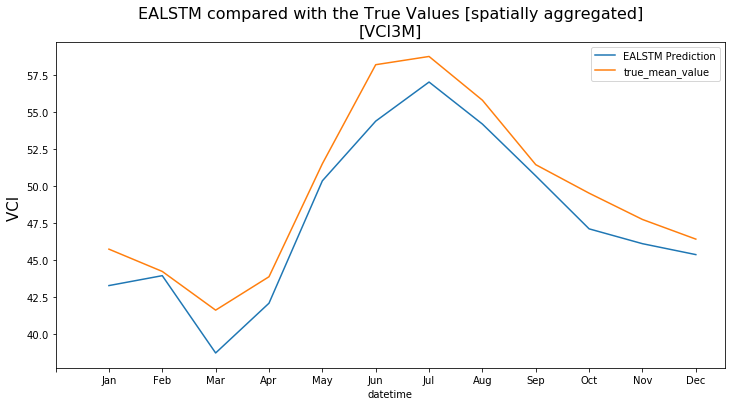

In [38]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'EALSTM Prediction'}).plot(ax=ax)
ax.set_title(f'EALSTM compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)

fig.savefig(f'/Users/tommylees/Downloads/ealstm_model_seasonality_{TARGET_VAR}.png')

# Paper Analysis

### Q1: RMSE for each District

In [39]:
from typing import Tuple, List, Dict, Optional

def analyze_region(
        region_name: str, 
        district_map: xr.Dataset, 
        model_experiment: str, 
        true_data_experiment: str,
        model: str,
        target_var: str = 'VCI') -> Tuple[float, float]:

    region_lookup: Dict = dict(
            zip(
                [v.strip() for v in district_map.attrs["values"].split(",")],
                [int(k.strip()) for k in district_map.attrs["keys"].split(",")],
            )
        )
    
    district_int = region_lookup[region_name]
    
    rmse: List[np.ndarray] = []
    
    for file_name in (data_dir / 'features' / true_data_experiment / 'test').glob("*"):
        year, month = file_name.name.split("_")
        
        # read the observed (true) data
        true_file = xr.open_dataset(file_name / "y.nc").where(
            district_map.district_l2 == district_int).rename({target_var: "preds"}
        ).isel(time=0)

        # read predictions
        model_file = xr.open_dataset(
            data_dir / 'models' / model_experiment / model / f"preds_{year}_{month}.nc"
        ).where(district_map.district_l2 == district_int)
        
        model_err = (model_file - true_file).preds.values
        model_err = model_err[~np.isnan(model_err)]
        rmse.append(np.sqrt(model_err ** 2))
    
    return np.concatenate(rmse).mean()


district_map = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_kenya.nc")

results: Dict[str, Dict[str, float]] = {}
for model in ["ealstm", "previous_month", "rnn"]:
    results[model] = {}
    for region in ["TURKANA", "MANDERA", "MARSABIT", "WAJIR"]:
        results[model][region] = analyze_region(
            region, 
            district_map, 
            EXPERIMENT,
            EXPERIMENT,
            model=model,
            target_var=TARGET_VAR
        )

In [40]:
results

{'ealstm': {'TURKANA': 5.135253021886078,
  'MANDERA': 5.579220876598683,
  'MARSABIT': 5.284210861610345,
  'WAJIR': 5.288354181740077},
 'previous_month': {'TURKANA': 10.21697447314141,
  'MANDERA': 8.789920445972829,
  'MARSABIT': 8.65305043659648,
  'WAJIR': 7.77496700089171},
 'rnn': {'TURKANA': 5.436351834296524,
  'MANDERA': 5.720054628311971,
  'MARSABIT': 5.435412124376105,
  'WAJIR': 5.355811147746093}}

### Q2: R2 for each District

In [41]:
data = analyzer.compute_regional_error_metrics()

for model in ["previous_month", "rnn", "ealstm"]:
    for region in ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]:
        row = data[(data.model == model) & (data.region_name == region) & 
                  (data.admin_level_name == "district_l2_kenya")]
        print(f"For {model} in {region}, r2: {row.r2.iloc[0]}, rmse: {row.rmse.iloc[0]}")

For previous_month in MANDERA, r2: 0.7893471715550818, rmse: 9.53938236417804
For previous_month in MARSABIT, r2: 0.847297828254277, rmse: 8.902548876544904
For previous_month in TURKANA, r2: 0.7420044439162268, rmse: 9.784037356564244
For previous_month in WAJIR, r2: 0.8820091293200599, rmse: 7.81592606733524
For rnn in MANDERA, r2: 0.955984556527762, rmse: 4.360528711240182
For rnn in MARSABIT, r2: 0.966565311053768, rmse: 4.165723146918052
For rnn in TURKANA, r2: 0.9430981253542946, rmse: 4.594891669592258
For rnn in WAJIR, r2: 0.9601001597340445, rmse: 4.545082997049586
For ealstm in MANDERA, r2: 0.942321061997229, rmse: 4.991662768248137
For ealstm in MARSABIT, r2: 0.9741950412495397, rmse: 3.6596819535148355
For ealstm in TURKANA, r2: 0.9611550109036691, rmse: 3.7964657957440524
For ealstm in WAJIR, r2: 0.9632411388904092, rmse: 4.3625183158132845


### Q3: VCI3M scores for 2016-17

In [42]:
from sklearn.metrics import r2_score

def rolling_average(district_csv: pd.DataFrame, years: Optional[List[int]] = None) -> Dict[str, float]:
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']
    assert len(district_csv.model.unique()) == 1, f"Expect ONE model. Got:{district_csv.model.unique()}"

    if years is None:
        years = [2016, 2017]  # to reflect the Adede paper

    district_csv["month"] = pd.to_datetime(district_csv.datetime).dt.month
    district_csv["year"] = pd.to_datetime(district_csv.datetime).dt.year
    
    # get years of interest
    data = district_csv[np.isin(district_csv.year, [2016, 2017])]
    
    output_dict: Dict[str: float] = {}
    
    # compute R2 for each district
    for district in relevant_districts:
        district_data = data.loc[data.region_name == district.upper()]
        mask = district_data.predicted_mean_value.isnull() | district_data.true_mean_value.isnull()

        district_score = r2_score(
            district_data.predicted_mean_value[~mask],
            district_data.true_mean_value[~mask]
        )
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    return output_dict

In [43]:
for model in ['previous_month', 'rnn', 'ealstm']:
    print(f"** MODEL: {model} **")
    rolling_average(
        district_csv=df.loc[df.model == model]
    )
    print()

** MODEL: previous_month **
For Mandera, r2 score: 0.6606010322487319
For Marsabit, r2 score: 0.7119467971038645
For Turkana, r2 score: 0.682689531155017
For Wajir, r2 score: 0.7320061867090064

** MODEL: rnn **
For Mandera, r2 score: 0.8362069097912503
For Marsabit, r2 score: 0.9331343419939753
For Turkana, r2 score: 0.9032782546833142
For Wajir, r2 score: 0.7487397667762355

** MODEL: ealstm **
For Mandera, r2 score: 0.812932685304466
For Marsabit, r2 score: 0.9387997429550986
For Turkana, r2 score: 0.9482732680632027
For Wajir, r2 score: 0.771434555557619



# Confusion Matrices

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Quintiles of Vegetation Condition Index

In [45]:
def calculate_quintiles(da: xr.DataArray, new_variable_name: str = 'quintiles'):
    bins = [0.0, 20.0, 40.0, 60.0, 80.0]
    result = xr.apply_ufunc(np.digitize, da, bins)
    result = result.rename(new_variable_name)
    return result

mask = get_ds_mask(ds[TARGET_VAR].isel(time=slice(-3, -1)))
true_qs = calculate_quintiles(y_test[TARGET_VAR]).where(~mask)
lstm_pred_qs = calculate_quintiles(lstm_pred.where(lstm_pred > 0, 0).load()).where(~mask)
ealstm_pred_qs = calculate_quintiles(ealstm_pred.where(ealstm_pred > 0, 0).load()).where(~mask)
bline_qs = calculate_quintiles(bline_pred.load()).where(~mask)

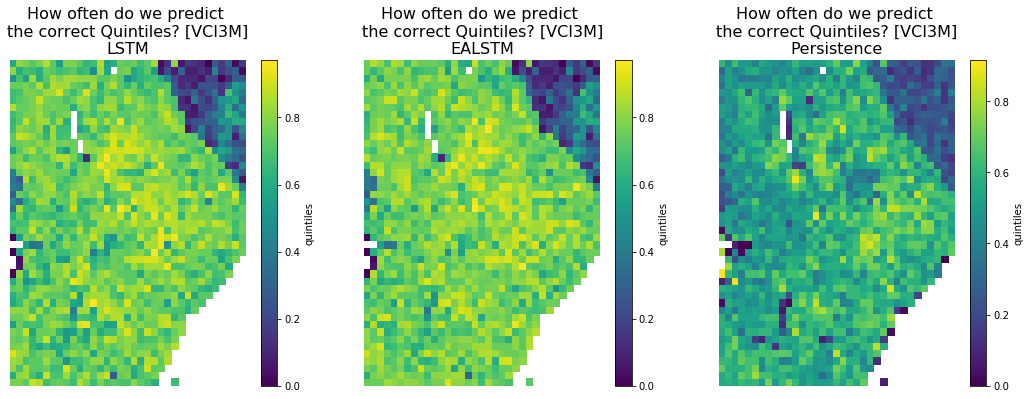

In [46]:
kwargs = {'vmin': 0, 'vmax': 0.8}

fig, axs = plt.subplots(1, 3, figsize=(18,6))
(lstm_pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[0])
axs[0].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nLSTM', size=16);

(ealstm_pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[1])
axs[1].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nEALSTM', size=16);

(bline_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[2])
axs[2].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nPersistence', size=16);

for ax in axs:
    ax.axis('off')

In [47]:
times = true_qs.time.values
true_np = true_qs.stack(pixel=['lat', 'lon']).values.flatten()
lstm_preds_np = lstm_pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
ealstm_preds_np = ealstm_pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
bline_np = bline_qs.stack(pixel=['lat', 'lon']).values.flatten()

In [48]:
# np.set_printoptions(precision=2)

# plot_confusion_matrix(true_np, preds_np, classes=None, normalize=True,
#                       title='EALSTM Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})
# plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
#                       title='BASELINE Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})

### test vegetation deficit index

    VCI3M Limits   | Description                        | Value
    -----------------------------------------------------------
    0 <= x <10     | Extreme vegetation deficit         |  1
    10 <= x <20    | Severe vegetation deficit          |  2
    20 <= x <35    | Moderate vegetation deficit        |  3
    35 <= x <50    | Normal vegetation conditions       |  4
    50 <= x <=100  | Above normal vegetation conditions |  5


In [49]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(y_test[TARGET_VAR], 'vdi')
vdi_lstm_pred = v.vegetation_index_classify(lstm_pred.load(), 'vdi')
vdi_ealstm_pred = v.vegetation_index_classify(ealstm_pred.load(), 'vdi')
vdi_bline = v.vegetation_index_classify(bline_pred.load(), 'vdi')

print(vdi_true.min(), vdi_true.max())


<xarray.DataArray 'vdi' ()>
array(0) <xarray.DataArray 'vdi' ()>
array(5)


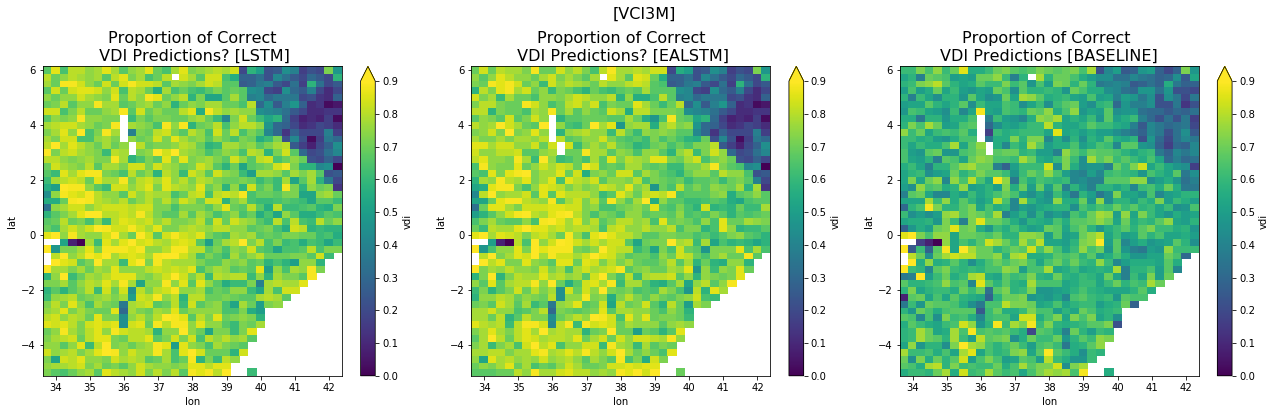

In [50]:
kwargs = {'vmin':0, 'vmax':0.9}

fig, axs = plt.subplots(1, 3, figsize=(18,6))
(vdi_lstm_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[0], **kwargs)
axs[0].set_title('Proportion of Correct\n VDI Predictions? [LSTM]', size=16);

(vdi_ealstm_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[1], **kwargs)
axs[1].set_title('Proportion of Correct\n VDI Predictions? [EALSTM]', size=16);

(vdi_bline == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[2], **kwargs)
axs[2].set_title('Proportion of Correct \nVDI Predictions [BASELINE]', size=16);

fig.suptitle(f'[{TARGET_VAR}]', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot the Vegetation Deficit Index (VDI) from Klisch & Atzberger 2016

In [51]:
print(true_np.shape)
print(lstm_preds_np.shape)
print(ealstm_preds_np.shape)
print(bline_np.shape)

(56700,)
(56700,)
(56700,)
(56700,)


Normalized confusion matrix
[[0.14353026 0.24574121 0.25407756 0.13610004 0.22055092]
 [0.09691071 0.21836648 0.24954154 0.15728594 0.27789533]
 [0.07145658 0.16741815 0.25142129 0.16781023 0.34189375]
 [0.047942   0.12511693 0.20030402 0.2046305  0.42200655]
 [0.01744347 0.04929161 0.10335846 0.13106279 0.69884368]]
Normalized confusion matrix
[[0.14353026 0.24574121 0.25407756 0.13610004 0.22055092]
 [0.09691071 0.21836648 0.24954154 0.15728594 0.27789533]
 [0.07145658 0.16741815 0.25142129 0.16781023 0.34189375]
 [0.047942   0.12511693 0.20030402 0.2046305  0.42200655]
 [0.01744347 0.04929161 0.10335846 0.13106279 0.69884368]]
Normalized confusion matrix
[[0.20097862 0.19300471 0.20641537 0.11471548 0.28488583]
 [0.14233319 0.17632952 0.21230075 0.12145578 0.34758076]
 [0.1122329  0.14252107 0.19878455 0.14840227 0.3980592 ]
 [0.07553789 0.10991581 0.17083723 0.15668849 0.48702058]
 [0.02857256 0.05189629 0.1119618  0.13189155 0.67567781]]


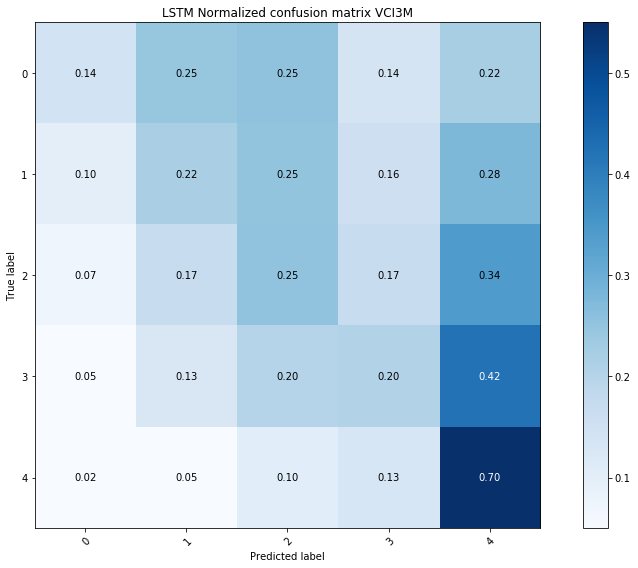

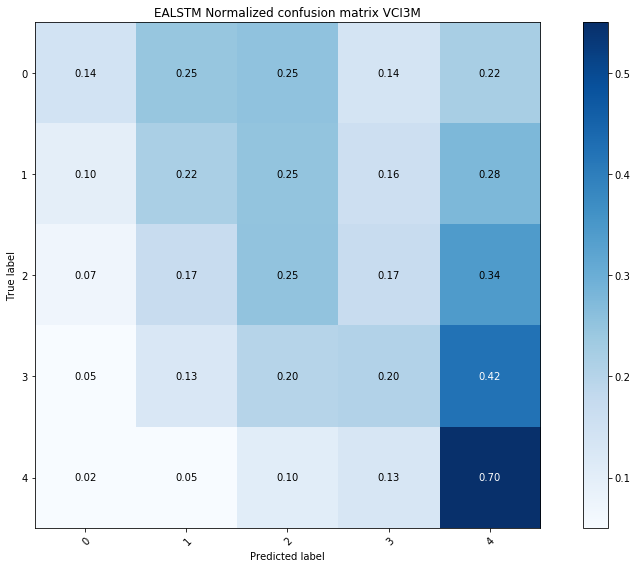

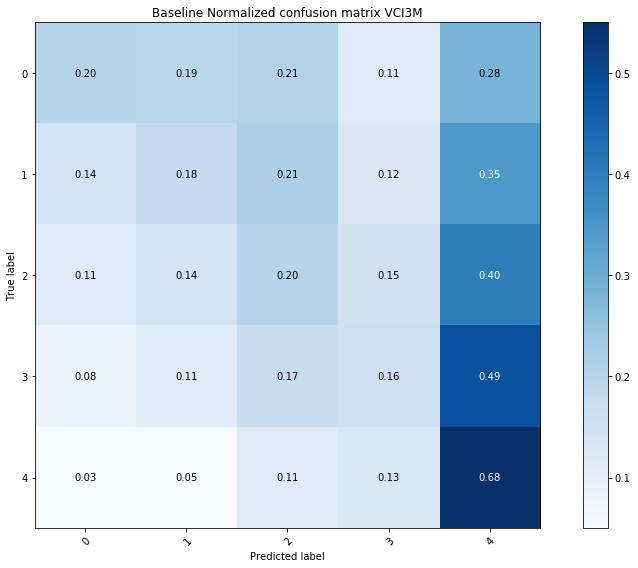

In [52]:
true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_lstm_np = vdi_lstm_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_ealstm_np = vdi_ealstm_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np = vdi_bline.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np, preds_lstm_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'LSTM Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});

plot_confusion_matrix(true_np, preds_lstm_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'EALSTM Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});

plot_confusion_matrix(true_np, bline_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'Baseline Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});